# Insulation & boundaries

Welcome to the contact insulation notebook!

Insulation is a simple concept, yet a powerful way to look at C data. Insulation is one aspect of locus-specific contact frequency at small genomic distances, and reflects the segmentation of the genome into domains.

Insulation can be computed with multiple methods. One of the most common methods involves using a diamond-window score to generate an ***insulation profile***. To compute this profile, slide a diamond-shaped window along the genome, with one of the corners on the main diagonal of the matrix, and sum up the contacts within the window for each position.

Insulation profiles reveal that certain locations have lower scores, reflecting lowered contact frequencies between upstream and downstream loci. These positions are often referred to as ***boundaries***, and are also obtained with multiple methods. Here we illustrate one thresholding method for determining boundaries from an insulation profile.

In this notebook we:

* Calculate the insulation score genome-wide and display it alongside an interaction matrix
* Call insulating boundaries
* Filter insulating boundaries based on their strength
* Calculate enrichment of CTCF/genes at boundaries
* Repeat boundary filtering based on enrichmnent of CTCF, a known insulator protein in mammalian genomes

In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from cooltools import insulation

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.1'):
    raise AssertionError("tutorials rely on cooltools version 0.5.1 or higher,"+
                         "please check your cooltools version and update to the latest")

In [3]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
import cooltools
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


## Calculating genome-wide contact insulation
Here we load the Hi-C data at 10 kbp resolution and calculate insulation score with 4 different window sizes

In [4]:
resolution = 10000  
clr = cooler.Cooler('test.mcool::resolutions/'+str(resolution))
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
insulation_table = insulation(clr, windows, verbose=True)

INFO:root:Processing region chr2
INFO:root:Processing region chr17


This function returns a dataframe where rows correspond to genomic bins of the cooler.

The columns of this insulation dataframe report the insulation score, the number of valid (non-nan) pixels, whether the given bin is valid, the boundary prominence (strength) and whether locus is called as a boundary after thresholding, for each of the window sizes provided to the function.

Below we print the information returned for any window size, as well as the specific information for the largest window used:

In [5]:
first_window_summary =insulation_table.columns[[ str(windows[-1]) in i for i in insulation_table.columns]]

insulation_table[['chrom','start','end','region','is_bad_bin']+list(first_window_summary)].iloc[1000:1005]

,chrom,start,end,region,is_bad_bin,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_250000,is_boundary_250000
1000,chr2,10000000,10010000,chr2,False,0.309791,622.0,NaN,False
1001,chr2,10010000,10020000,chr2,False,0.226045,622.0,NaN,False
1002,chr2,10020000,10030000,chr2,False,0.090809,622.0,NaN,False
1003,chr2,10030000,10040000,chr2,False,-0.101091,622.0,NaN,False
1004,chr2,10040000,10050000,chr2,False,-0.342858,622.0,NaN,False


In [6]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

Let's see what the insulation track at the highest resolution looks like, next to a rotated Hi-C matrix.

(10500000.0, 13200000.0)

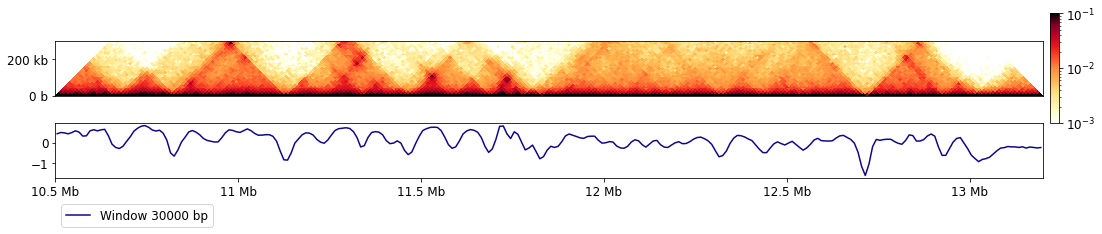

In [7]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
plt.rcParams['font.size'] = 12

start = 10_500_000
end = start+ 90*windows[0]
region = ('chr2', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)
f, ax = plt.subplots(figsize=(18, 6))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), 
            insul_region['log2_insulation_score_'+str(windows[0])],
            label=f'Window {windows[0]} bp')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

And now let's add the other window sizes.

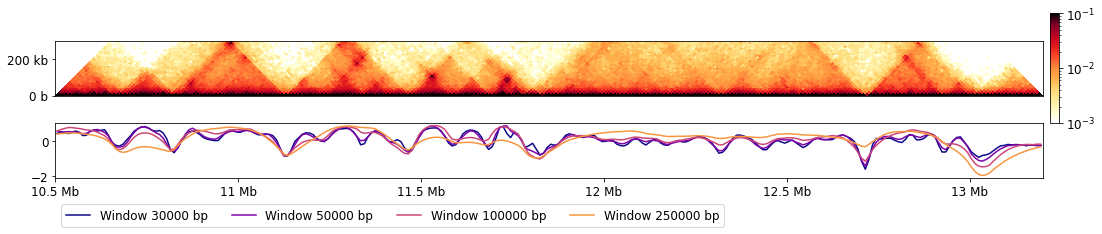

In [8]:
for res in windows[1:]:
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{res}'], label=f'Window {res} bp')
ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);
f

This really highlights how much the result is dependent on window size: smaller windows are sensitive to local structure, whereas large windows capture regions that insulate at larger scales.

## Boundary calling

The insulation table also has annotations for valleys of the insulation score, which correspond to highly insulating regions, such as TAD boundaries. All potential boundaries have an assigned `boundary_strength_` column. Additionally, this strength is thresholded to find regions that insulate particularly strongly, and this is recorded in the `is_boundary_` columns.

Let's repeat the previous plot and show where we found the boundaries:

(10500000.0, 13200000.0)

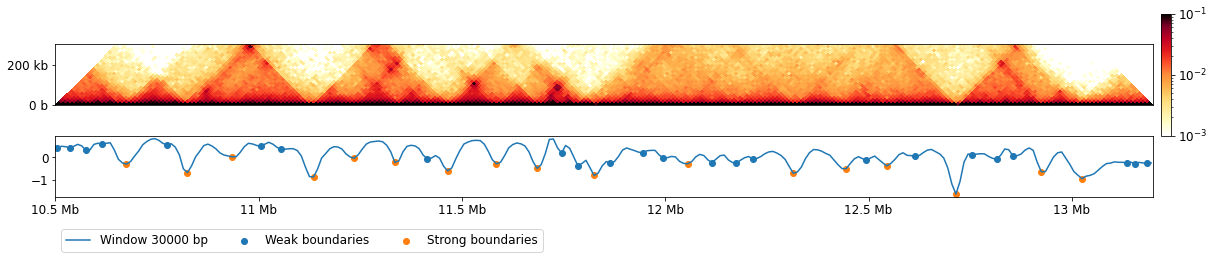

In [9]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[0]}'], label=f'Window {windows[0]} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1), 
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1), 
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])


## Calculating boundary strength

Let's inspect the histogram of boundary strengths to show how we selected the strong boundaries. 

First, boundary strength is calculated using the [peak prominence](https://en.wikipedia.org/wiki/Topographic_prominence), on the dips (or minima) of the insulation profile.

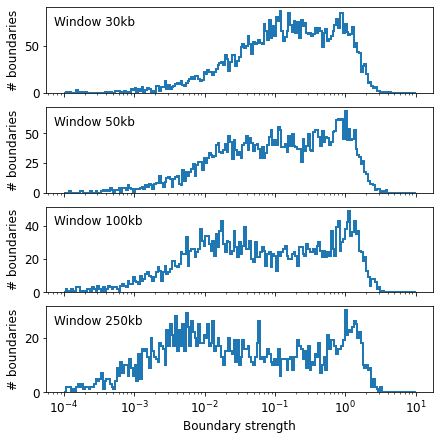

In [10]:
histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)

f, axs = plt.subplots(len(windows),1, sharex=True, figsize=(6,6), constrained_layout=True)
for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation_table[f'boundary_strength_{w}'],
        **histkwargs
    )
    ax.text(0.02, 0.9,
             f'Window {w//1000}kb', 
             ha='left',
             va='top',
             transform=ax.transAxes)
    
    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )
    
axs[-1].set(xlabel='Boundary strength');

As a quick way to automatically threshold the histogram, we  borrow the tresholding methods from the image analysis field. These include Li (default `threshold="Li"`) or Otsu, as implemented in [scikit-image](https://scikit-image.org/). Otsu is more conservative, whereas Li is more permissive.

In practice these thresholds work well for a simple parameter-free method for mammalian interphase data, though should be double-checked for any individual dataset.

[Text(0.5, 0, 'Boundary strength')]

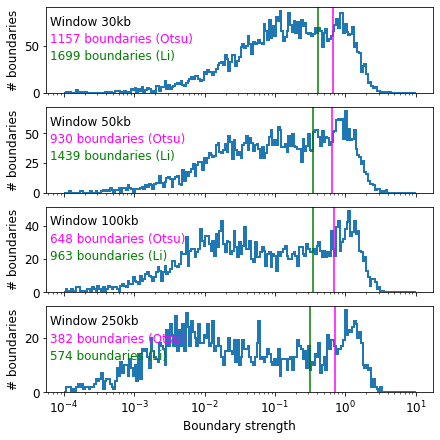

In [11]:
from skimage.filters import threshold_li, threshold_otsu

f, axs = plt.subplots(len(windows), 1, sharex=True, figsize=(6,6), constrained_layout=True)
thresholds_li = {}
thresholds_otsu = {}
for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation_table[f'boundary_strength_{w}'],
        **histkwargs
    )
    thresholds_li[w] = threshold_li(insulation_table[f'boundary_strength_{w}'].dropna().values)
    thresholds_otsu[w] = threshold_otsu(insulation_table[f'boundary_strength_{w}'].dropna().values)
    n_boundaries_li = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_li[w]).sum()
    n_boundaries_otsu = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_otsu[w]).sum()
    ax.axvline(thresholds_li[w], c='green')
    ax.axvline(thresholds_otsu[w], c='magenta')
    ax.text(0.01, 0.9,
             f'Window {w//1000}kb', 
             ha='left',
             va='top',
             transform=ax.transAxes)
    ax.text(0.01, 0.7,
            f'{n_boundaries_otsu} boundaries (Otsu)',
            c='magenta',
            ha='left',
            va='top',
            transform=ax.transAxes)  
    ax.text(0.01, 0.5,
            f'{n_boundaries_li} boundaries (Li)',
            c='green',
            ha='left',
            va='top',
            transform=ax.transAxes)
  
    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )
    
axs[-1].set(xlabel='Boundary strength')

## CTCF enrichment at boundaries

TAD boundaries are frequently associated with CTCF binding. 

To quantify this, we can aggregate the ChIP-Seq singal around the boundaries, and compare enrichment of CTCF with boundary strength using [pybbi](https://github.com/nvictus/pybbi) (https://github.com/nvictus/pybbi). We provide a test bigWig file with CTCF enrichment over input for the same cell type as the Micro-C data.

We use the `bbi.stackup()` method with no binning to extract an array of average values for all boundary regions with 1 kbp flanks.

In [12]:
# Download test data. The file size is 592 Mb, so the download might take a while:
ctcf_fc_file = cooltools.download_data("HFF_CTCF_fc", cache=True, data_dir='./')

In [13]:
import bbi

In [14]:
is_boundary = np.any([
        ~insulation_table[f'boundary_strength_{w}'].isnull() 
        for w in windows],
    axis=0)
boundaries = insulation_table[is_boundary]
boundaries.head()

,chrom,start,end,region,is_bad_bin,log2_insulation_score_30000,n_valid_pixels_30000,log2_insulation_score_50000,n_valid_pixels_50000,log2_insulation_score_100000,...,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_30000,boundary_strength_50000,boundary_strength_250000,boundary_strength_100000,is_boundary_30000,is_boundary_50000,is_boundary_100000,is_boundary_250000
5,chr2,50000,60000,chr2,False,0.089080,6.0,0.059578,22.0,0.586104,...,1.211581,122.0,NaN,0.156397,NaN,NaN,False,False,False,False
6,chr2,60000,70000,chr2,False,0.036906,6.0,0.134037,22.0,0.547732,...,1.161302,147.0,0.150452,NaN,NaN,NaN,False,False,False,False
7,chr2,70000,80000,chr2,False,0.062353,6.0,0.122444,22.0,0.479052,...,1.092480,172.0,NaN,0.011593,NaN,NaN,False,False,False,False
9,chr2,90000,100000,chr2,False,0.049426,6.0,0.198381,22.0,0.377645,...,0.972715,222.0,0.029686,NaN,NaN,NaN,False,False,False,False
11,chr2,110000,120000,chr2,False,0.095762,6.0,0.190455,22.0,0.320182,...,0.867080,272.0,NaN,0.024922,NaN,NaN,False,False,False,False


In [15]:
# Calculate the average ChIP singal/input in the 3kb region around the boundary.  
flank = 1000 # Length of flank to one side from the boundary, in basepairs
ctcf_chip_signal = bbi.stackup(
    './test_CTCF.bigWig', 
    boundaries.chrom, 
    boundaries.start-flank, 
    boundaries.end+flank, 
    bins=1).flatten()

Real boundaries are often enriched in CTCF binding, and this can be used as a guide for thresholding the boundary strength. However note a small population of strong boundaries without CTCF binding.

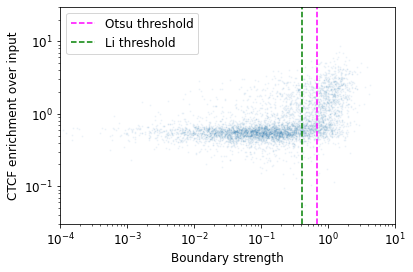

In [16]:
w=windows[0]
f, ax = plt.subplots()
ax.loglog(
    boundaries[f'boundary_strength_{w}'], 
    ctcf_chip_signal,
    'o',
    markersize=1,
    alpha=0.05
);
ax.set(
    xlim=(1e-4,1e1),
    ylim=(3e-2,3e1),
    xlabel='Boundary strength',
    ylabel='CTCF enrichment over input')

ax.axvline(thresholds_otsu[w], ls='--', color='magenta', label='Otsu threshold')
ax.axvline(thresholds_li[w], ls='--', color='green', label='Li threshold')
ax.legend()

If we were interested specifically in boundaries with CTCF, we could threshold based on enrichment of CTCF ChIP-seq:

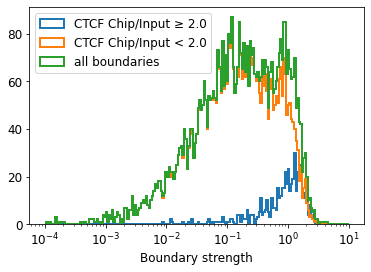

In [17]:
histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)
f, ax = plt.subplots()
ax.set(xscale='log', xlabel='Boundary strength')
ax.hist(
    boundaries[f'boundary_strength_{windows[0]}'][ctcf_chip_signal>=2],
    label='CTCF Chip/Input ≥ 2.0',
    **histkwargs
);
ax.hist(
    boundaries[f'boundary_strength_{windows[0]}'][ctcf_chip_signal<2],
    label='CTCF Chip/Input < 2.0',
    **histkwargs
);
ax.hist(
    boundaries[f'boundary_strength_{windows[0]}'],
    label='all boundaries',
    **histkwargs
);
ax.legend(loc='upper left')

## 1D pileup: CTCF enrichment at boundaries

Additionally, we can create 1D pileup plot of average CTCF enrichment.

First, create a collection of genomic regions of equal size, each centered at the position of the boundary. 

Then, create a **stackup** of binned ChIP-Seq signal for these regions. It is based on the same test bigWig file with the CTCF ChIP-Seq log fold change over input. 

Finally, create **1D pileup** by averaging each stacked window.

In [18]:
# Select the strict thresholded boundaries for one window size
top_boundaries = insulation_table[insulation_table[f'boundary_strength_{windows[1]}']>=thresholds_otsu[windows[1]]]

In [19]:
# Create of the stackup, the flanks are +- 50 Kb, number of bins is 100 : 
flank = 50000 # Length of flank to one side from the boundary, in basepairs
nbins = 100   # Number of bins to split the region
stackup = bbi.stackup('./test_CTCF.bigWig', 
                      top_boundaries.chrom, 
                      top_boundaries.start+resolution//2-flank, 
                      top_boundaries.start+resolution//2+flank, 
                      bins=nbins)

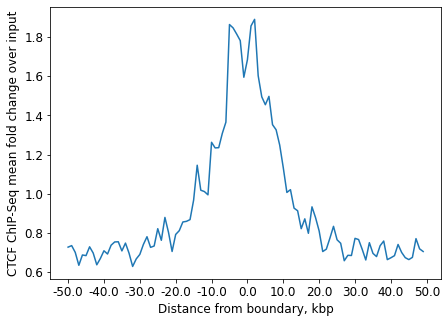

In [20]:
f, ax = plt.subplots(figsize=[7,5])
ax.plot(np.nanmean(stackup, axis=0) )
ax.set(xticks=np.arange(0, nbins+1, 10),
       xticklabels=(np.arange(0, nbins+1, 10)-nbins//2)*flank*2/nbins/1000,
       xlabel='Distance from boundary, kbp',
       ylabel='CTCF ChIP-Seq mean fold change over input');